In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
import numpy as np
from data_work import data_split
from data_work import processed
from data_work import analyse_dataset
from data_work import set_data
from model import Net
from sklearn.model_selection import train_test_split
df=pd.read_csv("/Users/mac/Dev/data/dta_IoT/new2test.csv")
#delete all null columns
id=[16,17,21,22,23,24]
col=df.columns
for idx in id:
    df=df.drop(col[idx],axis=1)
data=processed(df,"subcategory ")
names=["attack","category","subcategory "]
analyse_dataset(data,names)

thống kê nhãn attack:
1 6095
0 931
thống kê nhãn category:
2 1992
1 931
0 2994
3 1109
thống kê nhãn subcategory :
4 992
3 931
1 994
6 1000
7 1000
5 1000
2 995
0 114


In [2]:

traindata,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data['subcategory '])
data = traindata.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
client_data,server_data=train_test_split(traindata,test_size=0.2,random_state=42,stratify=data['subcategory '])
client_data = client_data.reset_index(drop=True)
server_data = server_data.reset_index(drop=True)

In [3]:
testdata_list=set_data([test_data])[0]
serverlist=set_data([server_data])[0]

len X 1406, len y 1406
len X 1124, len y 1124


# iid dataset setup 

In [4]:
trainloaders,testloaders=data_split(client_data,"subcategory ",4,0.1,IID=1)

prepairing IID dataset
len of client data :4496, len of each subdata : 1124
client number 1 : train(1012), val(112)
client number 2 : train(1012), val(112)
client number 3 : train(1012), val(112)
client number 4 : train(1012), val(112)


In [5]:
BATCH_SIZE=10
NUM_CLIENTS=4
NUM_ROUNDS =3

In [6]:
from model import Net

In [7]:
trainlist=set_data(trainloaders)
testlist=set_data(testloaders)

len X 1012, len y 1012
len X 1012, len y 1012
len X 1012, len y 1012
len X 1012, len y 1012
len X 112, len y 112
len X 112, len y 112
len X 112, len y 112
len X 112, len y 112


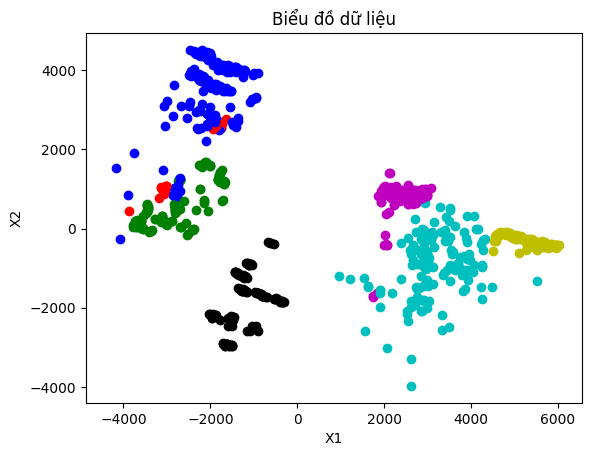

In [8]:
from sklearn.decomposition import PCA


# Khởi tạo PCA với số thành phần chính cần giữ lại là 2
pca = PCA(n_components=2)

# Thực hiện phân tích PCA trên dữ liệu
X_reduced = pca.fit_transform(trainlist[1][0])
import matplotlib.pyplot as plt


# Plot dữ liệu
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w'] # Màu sắc tương ứng với các nhãn
for i in range(len(X_reduced)):
    plt.scatter(X_reduced[i][0], X_reduced[i][1], color=colors[trainlist[1][1][i]])

# Đặt nhãn cho trục x và y
plt.xlabel('X1')
plt.ylabel('X2')

# Đặt tiêu đề cho đồ thị
plt.title('Biểu đồ dữ liệu')

# Hiển thị đồ thị
plt.show()

##Create model function

In [9]:
dropout_rate=0.00
learning_rate=0.01
model=Net(dropout_rate)

In [10]:
import torch
import torch.nn as nn

In [11]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

#4.Implement FedAvg algorithm

 ## Initialize model weights

###Cross validation

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Sử dụng cross-validation để đánh giá mô hình
for i in range(1):
    print(f"{i} set")
    print(f"working for client {i+1}")
    X =torch.tensor(trainlist[i][0].values)
    y = torch.tensor(trainlist[i][1].values)
    model.Cross_validation(X,y,5,learning_rate)

   

0 set
working for client 1
length of trainset 809, length of testset203
Accuracy for fold 1 : 0.1625615763546798
length of trainset 809, length of testset203
Accuracy for fold 2 : 0.6551724137931034
length of trainset 810, length of testset202
Accuracy for fold 3 : 0.9801980198019802
length of trainset 810, length of testset202
Accuracy for fold 4 : 0.9554455445544554
length of trainset 810, length of testset202
Accuracy for fold 5 : 0.9801980198019802


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna

def objective(trial,trainset,valset):
    X_train, y_train = trainlist[0][0],trainlist[0][1]
    X_val, y_val = testlist[0][0],testlist[0][1]
    X_train=torch.tensor(X_train.values)
    X_train=X_train.float()
    X_val=torch.tensor(X_val.values)
    X_val=X_val.float()
    y_train=torch.tensor(y_train.values)
    y_train=y_train.float()
    y_val=torch.tensor(y_val.values)
    y_val=y_val.float()

    train_size=len(X_train)
    val_size=len(X_val)

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    model = Net(0.00)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(1):
        running_loss = 0.0
        for i in range(train_size):
            inputs, labels = X_train[i], y_train[i]  # Get individual input and label tensors
            optimizer.zero_grad()
            outputs = model(inputs)  # Unsqueeze inputs to add batch dimension
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss = running_loss / len(X_train)

    model.eval()
    with torch.no_grad():
        inputs, labels = X_val, y_val
        outputs=model(inputs)
        _, predicted = torch.max(outputs.data,-1)
        accuracy = (predicted == labels.long()).sum().item() / labels.size(0)
    return 1-accuracy

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, trainlist[0], testlist[0]), n_trials=50)
best_params = study.best_params
best_learning_rate = best_params['learning_rate']

[I 2024-03-20 10:47:31,486] A new study created in memory with name: no-name-d9e1ba25-4442-409d-b947-1f2a7dccb4f1
[I 2024-03-20 10:47:31,912] Trial 0 finished with value: 0.0535714285714286 and parameters: {'learning_rate': 0.00013541492536330282}. Best is trial 0 with value: 0.0535714285714286.
[I 2024-03-20 10:47:32,291] Trial 1 finished with value: 0.8482142857142857 and parameters: {'learning_rate': 0.019423045117053686}. Best is trial 0 with value: 0.0535714285714286.
[I 2024-03-20 10:47:32,678] Trial 2 finished with value: 0.1785714285714286 and parameters: {'learning_rate': 1.2241215954691882e-05}. Best is trial 0 with value: 0.0535714285714286.
[I 2024-03-20 10:47:33,057] Trial 3 finished with value: 0.8482142857142857 and parameters: {'learning_rate': 0.006157149390917553}. Best is trial 0 with value: 0.0535714285714286.
[I 2024-03-20 10:47:33,429] Trial 4 finished with value: 0.9196428571428571 and parameters: {'learning_rate': 0.008527560862637663}. Best is trial 0 with valu

In [14]:
print(best_learning_rate)

0.00047587394662068215


In [15]:
model_IID=Net(0.00)
for i in range(4):
    print(f"working for client {i+1}")
    X =torch.tensor(trainlist[i][0].values)
    y = torch.tensor(trainlist[i][1].values)
    model_IID.Cross_validation(X,y,5,best_learning_rate)

working for client 1
length of trainset 809, length of testset203
Accuracy for fold 1 : 0.6403940886699507
length of trainset 809, length of testset203
Accuracy for fold 2 : 0.8866995073891626
length of trainset 810, length of testset202
Accuracy for fold 3 : 0.9851485148514851
length of trainset 810, length of testset202
Accuracy for fold 4 : 0.9752475247524752
length of trainset 810, length of testset202
Accuracy for fold 5 : 0.9851485148514851
working for client 2
length of trainset 809, length of testset203
Accuracy for fold 1 : 0.9605911330049262
length of trainset 809, length of testset203
Accuracy for fold 2 : 0.9605911330049262
length of trainset 810, length of testset202
Accuracy for fold 3 : 0.9900990099009901
length of trainset 810, length of testset202
Accuracy for fold 4 : 1.0
length of trainset 810, length of testset202
Accuracy for fold 5 : 0.995049504950495
working for client 3
length of trainset 809, length of testset203
Accuracy for fold 1 : 0.9901477832512315
length 

In [16]:
trainloaders,testloaders=data_split(client_data,"subcategory ",4,0.1,IID=0)

prepairing non IID dataset
len of client data :4496, len of each subdata : 1124
client number 1 : train(1012), val(112)
client number 2 : train(1012), val(112)
client number 3 : train(1012), val(112)
client number 4 : train(1012), val(112)


In [17]:
trainlist=set_data(trainloaders)
testlist=set_data(testloaders)

len X 1012, len y 1012
len X 1012, len y 1012
len X 1012, len y 1012
len X 1012, len y 1012
len X 112, len y 112
len X 112, len y 112
len X 112, len y 112
len X 112, len y 112


In [18]:
names=["subcategory "]
analyse_dataset(trainloaders[0],names)

thống kê nhãn subcategory :
1 573
2 373
0 66


In [19]:
model_NonIID=Net(0.00)
optimizer = torch.optim.RMSprop(model_NonIID.parameters(), lr=best_learning_rate)
criterion = nn.CrossEntropyLoss()

In [20]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Sử dụng cross-validation để đánh giá mô hình
for i in range(4):
    print(f"working for client {i}")
    X = torch.cat([torch.tensor(trainlist[i][0].values), torch.tensor(testlist[i][0].values)], dim=0)
    y = torch.cat([torch.tensor(trainlist[i][1].values), torch.tensor(testlist[i][1].values)], dim=0)
    model_NonIID.Cross_validation(X,y,5,0.002)

   

working for client 0
length of trainset 899, length of testset225
Accuracy for fold 1 : 0.8533333333333334
length of trainset 899, length of testset225
Accuracy for fold 2 : 0.9777777777777777
length of trainset 899, length of testset225
Accuracy for fold 3 : 0.9866666666666667
length of trainset 899, length of testset225
Accuracy for fold 4 : 0.9955555555555555
length of trainset 900, length of testset224
Accuracy for fold 5 : 0.9955357142857143
working for client 1
length of trainset 899, length of testset225
Accuracy for fold 1 : 0.7422222222222222
length of trainset 899, length of testset225
Accuracy for fold 2 : 0.9911111111111112
length of trainset 899, length of testset225
Accuracy for fold 3 : 1.0
length of trainset 899, length of testset225
Accuracy for fold 4 : 1.0
length of trainset 900, length of testset224
Accuracy for fold 5 : 1.0
working for client 2
length of trainset 899, length of testset225
Accuracy for fold 1 : 0.8622222222222222
length of trainset 899, length of te

In [21]:
def evaluate(model, X_test,y_test):
        model.eval()
        X_test=torch.tensor(X_test.values).float()
        y_test=torch.tensor(y_test.values)
        outputs=model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test.long()).sum().item() / y_test.size(0)
        print(f'Accuracy for testset : {accuracy}')

In [22]:
serverlist[0]

,pkSeqID,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,...,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category
0,4501,4857,0,2,3,3502,20,900,9,432,...,1794,5,4,437,81,1183,1091,940,1,0
1,6182,3685,0,3,0,468,25,901,9,92,...,2038,9,0,71,0,369,553,0,1,0
2,2143,1947,0,2,3,3079,20,381,1,9,...,10,0,1,0,1,2498,0,0,1,2
3,5161,2670,7,2,1,1266,22,901,2,70,...,0,2,0,63,0,33,28,0,1,0
4,4940,5296,0,2,3,3657,20,900,9,295,...,1908,5,4,237,81,770,617,415,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,4647,5003,0,2,1,3708,25,900,9,675,...,1933,5,4,366,110,505,378,184,1,0
1120,4414,4770,0,2,0,3293,25,900,9,590,...,1578,5,4,220,110,282,110,268,1,0
1121,3069,5642,0,2,3,1141,20,372,5,66,...,379,2,3,50,20,2179,1617,1376,1,3
1122,2537,2219,0,2,3,3079,20,270,1,9,...,138,0,1,0,1,2338,0,0,1,2


In [27]:
serverlist[1]

0       1
1       7
2       4
3       6
4       1
       ..
1119    1
1120    1
1121    2
1122    4
1123    4
Name: subcategory , Length: 1124, dtype: int64

In [23]:
loss_Non,NonIID_score=model_NonIID.evaluate(testdata_list[0],testdata_list[1])
loss_IID,IID_score=model_IID.evaluate(testdata_list[0],testdata_list[1])

In [24]:
print(loss_Non)

14.83785343170166


In [25]:
print(f"score of NonIID dataset : {NonIID_score}")
print(f"score of IID dataset : {IID_score}")

score of NonIID dataset : 0.492176386913229
score of IID dataset : 0.9964438122332859


In [26]:
import flwr as fl
from flwr.common import Metrics
class FlowerClient(fl.client.NumPyClient):
    '''
    trainset yêu cầu ở đây là 1 tensor bao gồm 2 tensor con, 1 là X, và 2 là y
    '''
    def __init__(self, cid, net, trainset, testset):
        self.cid = cid
        self.model = net
        self.trainset = trainset
        self.testset = testset

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return self.model.G.get_parameter()


    def merge_trainset(self,sv_trainset):
        merged_df = pd.concat([self.trainset, sv_trainset], axis=1) # trainset in dataframe type
            # Shuffle DataFrame
        shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        ##batch_size = config["batch_size"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")

        # Update local model parameters
        self.model.load_parameter(parameters)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=best_learning_rate)

        # Train the model
        self.model.train()
        history=self.model.fit(
            self.trainset[0],
            self.trainset[1],
            learning_rate=best_learning_rate,
            num_epochs = local_epochs,
            val_size=0.3,
        )

        # Return updated model parameters and results
        parameters_prime = self.model.get_parameter()
        num_examples_train = len(self.trainset[0])
        results = {
            "loss": history["loss"][-1],
            "accuracy": history["accuracy"][-1],
            "val_loss": history["val_loss"][-1],
            "val_accuracy": history["val_accuracy"][-1],
        }
        
        return parameters_prime, num_examples_train, results

    def evaluate(self, parameters, config):
        """Evaluate parameters on the locally held test set."""
        print(f"[Client {self.cid}] evaluate, config: {config}")
        # Update local model with global parameters
        self.model.load_parameter(parameters)

        # Evaluate global model parameters on the local test data and return results
        loss, accuracy = self.model.evaluate(self.testset[0], self.testset[1])
        num_examples_test = len(self.testset[0])
        return loss, num_examples_test, {"accuracy": accuracy}

##Client

In [27]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net(0.00)
    print(cid)
    trainset = trainlist[int(cid)]
    testset = testlist[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(cid, net, trainset, testset)

In [28]:
print(len(testdata_list[0]))

1406


##Server

In [42]:
from typing import Dict, Optional, Tuple
def get_evaluate_fn(model, weight_storage):
    """Return an evaluation function for server-side evaluation."""
    # x_val, y_val = vallist[0]
    y_test=testdata_list[1]
    X_test=testdata_list[0]
    # The `evaluate` function will be called after every round
    def evaluate(
        server_round: int,
        parameters: dict,
        config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
        model.load_parameter(parameters)  # Chuyển đổi thành từ điển và cập nhật model với các thông số mới nhất
        weight_storage.append(parameters)
        loss, accuracy = model.evaluate(X_test, y_test)
        return loss, {"accuracy": accuracy}
    return evaluate


def get_evaluate_fn_plot(model, y_plot):
    """Return an evaluation function for server-side evaluation."""
    global testdata_list
    y_test=testdata_list[1]
    X_test=testdata_list[0]
    # The `evaluate` function will be called after every round
    def evaluate(
        server_round: int,
        parameters: dict,
        config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
        model.load_parameter(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(X_test, y_test)
        if server_round == NUM_ROUNDS:
          y_plot.append(accuracy)
        return loss, {"accuracy": accuracy}

    return evaluate

In [30]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 5, #
        "lerning_rate": best_learning_rate,
    }
    return config

#Train models with IID and non-IID data  

##IID data

In [31]:
trainloaders,testloaders=data_split(client_data,"subcategory ",8,0.1,IID=1)

trainlist=set_data(trainloaders)
testlist=set_data(testloaders)


prepairing IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56


In [32]:
NUM_CLIENTS=8
NUM_ROUNDS=5
model=Net(0.00)
params=model.get_parameter()

In [33]:
IID_weight_storage = []
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg( # Có thể tùy chọn chiến lược khác như FedAdagrad
    fraction_fit=1,  # Tỷ lệ các thiết bị người dùng được chọn để huấn luyện
    fraction_evaluate=1,  # Tỷ lệ các thiết bị người dùng được chọn để đánh giá hiệu suất
    min_fit_clients=NUM_CLIENTS,  # Số tối thiểu các thiết bị người dùng cần có trong quá trình huấn luyện
    min_evaluate_clients=8,  # Số tối thiểu các thiết bị người dùng cần có trong quá trình đánh giá
    min_available_clients=NUM_CLIENTS,  # Wait until all 10 clients are available
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=get_evaluate_fn(model,IID_weight_storage),  # Pass the evaluation function
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)

# Start simulation
fl.simulation.start_simulation( # Mô phỏng bằng cách gọi hàm
    client_fn=client_fn, # Một hàm để tạo ra các máy khách
    num_clients=NUM_CLIENTS, # Số lượng máy khách
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS), # Cấu hình cho máy chủ
    strategy=strategy, # Chiến lược huấn luyện và tổ chức dữ liệu
)
wf_IID=IID_weight_storage[2]

INFO flwr 2024-02-25 14:19:38,585 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-02-25 14:19:40,570	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:19:41,138 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7329896858.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7329896858.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-25 14:19:41,138 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:19:41,138 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
IN

(DefaultActor pid=15069) 6
(DefaultActor pid=15069) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}
(DefaultActor pid=15069) [Client 1] evaluate, config: {}


DEBUG flwr 2024-02-25 14:19:46,563 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:19:46,597 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
INFO flwr 2024-02-25 14:19:46,602 | server.py:125 | fit progress: (4, 0.2912830412387848, {'accuracy': 0.9601706970128022}, 5.442219167001895)
INFO:flwr:fit progress: (4, 0.2912830412387848, {'accuracy': 0.9601706970128022}, 5.442219167001895)
DEBUG flwr 2024-02-25 14:19:46,603 | server.py:173 | evaluate_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:19:46,638 | server.py:187 | evaluate_round 4 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 8 results and 0 failures
DEBUG flwr 2024-02-25 14:19:46,639 | server.py:222 | fit_round 5: strategy sampled 8 clients

##Non-IID dataset

###Non-IID1 dataset

In [34]:
trainloaders,testloaders=data_split(client_data,"subcategory ",8,0.1,IID=0)

trainlist=set_data(trainloaders)
testlist=set_data(testloaders)

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
(DefaultActor pid=15067) 4
(DefaultActor pid=15067) [Client 4] evaluate, config: {}
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15072) 3
(DefaultActor pid=15072) [Client 3] evaluate, config: {}


In [35]:
NUM_CLIENTS=8
NUM_ROUNDS=5
model=Net(0.00)
params=model.get_parameter()

In [38]:
Non_IID2_weight_storage = []
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg( # Có thể tùy chọn chiến lược khác như FedAdagrad
    fraction_fit=1,  # Tỷ lệ các thiết bị người dùng được chọn để huấn luyện
    fraction_evaluate=1,  # Tỷ lệ các thiết bị người dùng được chọn để đánh giá hiệu suất
    min_fit_clients=NUM_CLIENTS,  # Số tối thiểu các thiết bị người dùng cần có trong quá trình huấn luyện
    min_evaluate_clients=8,  # Số tối thiểu các thiết bị người dùng cần có trong quá trình đánh giá
    min_available_clients=NUM_CLIENTS,  # Wait until all 10 clients are available
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=get_evaluate_fn(model,Non_IID2_weight_storage),  # Pass the evaluation function
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)

# Start simulation
fl.simulation.start_simulation( # Mô phỏng bằng cách gọi hàm
    client_fn=client_fn, # Một hàm để tạo ra các máy khách
    num_clients=NUM_CLIENTS, # Số lượng máy khách
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS), # Cấu hình cho máy chủ
    strategy=strategy, # Chiến lược huấn luyện và tổ chức dữ liệu
)
wf_noIID2 = Non_IID2_weight_storage[2]

INFO flwr 2024-02-25 14:23:42,615 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-02-25 14:23:46,255	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:23:46,931 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7980236800.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7980236800.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2024-02-25 14:23:46,932 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:23:4

(DefaultActor pid=15219) 2
(DefaultActor pid=15219) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}
(DefaultActor pid=15219) [Client 3] evaluate, config: {}


INFO flwr 2024-02-25 14:23:53,531 | server.py:125 | fit progress: (3, 1.0488965511322021, {'accuracy': 0.8300142247510669}, 6.436842290990171)
INFO:flwr:fit progress: (3, 1.0488965511322021, {'accuracy': 0.8300142247510669}, 6.436842290990171)
DEBUG flwr 2024-02-25 14:23:53,532 | server.py:173 | evaluate_round 3: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 3: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:23:53,693 | server.py:187 | evaluate_round 3 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 8 results and 0 failures
DEBUG flwr 2024-02-25 14:23:53,701 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:23:53,784 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
INFO flwr 2024-02-25 14:23:53,789 | server.py:125 | fit progress: (4, 1.9688866138458252, {'

(DefaultActor pid=15219) 0
(DefaultActor pid=15219) [Client 0] evaluate, config: {}


###Non-IID2 dataset

##SGD model

In [39]:
from sklearn.datasets import load_iris
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

df = data.sample(frac=1).reset_index(drop=True) #shuffle dataset
X = (data.drop(columns = ['subcategory ']))
y = data ['subcategory ']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

sgd_classifier = SGDClassifier(random_state=42, loss='perceptron', shuffle = True)
sgd_classifier.fit(X_train, y_train)

y_pred = sgd_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)

print(f'accuracy: {accuracy}')
wsgd = sgd_classifier.coef_

accuracy: 0.994661921708185


#6. Analyze weight divergence

##Compute weight divergence

In [40]:
#print("MLP:", wf_IID)
# print((wf_IID[0]))

print("SGD:", wsgd)

SGD: [[ 12.88757799   4.93180468  -1.14899875  -3.44868393   0.25841505
    6.96959073  -2.70035687  -7.27251321   1.14076563  -0.88221928
    1.48293826   4.0037615  -10.16907369  -1.3755771    0.69689168
   -2.1080656    0.17147307   6.98034957   1.3983017   -3.51691922
    5.43940103  -0.63504478  -1.21889179   1.88740666  13.99517755
   16.8209756    5.20092701  11.05608194]
 [  5.63840756   9.62201096  -2.97943924  -6.61431337  -4.66046754
   12.38487194  -3.15954871   9.84472705  -2.83635498   3.61631182
    8.51155881   7.80737532  -5.65621531   2.48059069   0.26546165
    0.85322292  -0.51121145  -1.28473864   0.74213934  -5.08656394
   -0.46050287   2.92736539  12.84463466  -2.30067429   5.29028722
    5.7362746    5.0187081  -14.09893844]
 [-13.07451264  19.94018233  -0.49940516  -6.23966285   3.42286349
   -2.70348053  -3.16937241  -2.97078826  -1.26502975   1.73575275
    1.39395264  20.77457111  -5.78439331  -4.06883017  -3.37778442
   -2.49642378  -1.36770008   0.34747846

##Plot weight divergence versus model layer

#7. Evaluate data sharing strategy

##Change in G_size

In [43]:
x_plot = []
y_plot = []
import random
for G_size in range(25,251,25):
  test_size = G_size/1000
  df_client,df_global=train_test_split(traindata,test_size=test_size)
  global trainlist
  global testlist
  
  trainloaders,testloaders=data_split(client_data,"subcategory ",8,0.1,IID=0)
  trainlist=set_data(trainloaders)
  testist=set_data(testloaders)

  #Merge G with local client data
  for trainloader in trainloaders:
    trainloader = pd.concat([trainloader, df_global])
    trainloader = trainloader.sample(frac=1).reset_index(drop=True)
  x_plot.append(test_size)
  
  #simulate
  strategy = fl.server.strategy.FedAvg( # Có thể tùy chọn chiến lược khác như FedAdagrad
      fraction_fit=1,  # Tỷ lệ các thiết bị người dùng được chọn để huấn luyện
      fraction_evaluate=0.5,  # Tỷ lệ các thiết bị người dùng được chọn để đánh giá hiệu suất
      min_fit_clients=NUM_CLIENTS,  # Số tối thiểu các thiết bị người dùng cần có trong quá trình huấn luyện
      min_evaluate_clients=5,  # Số tối thiểu các thiết bị người dùng cần có trong quá trình đánh giá
      min_available_clients=NUM_CLIENTS,  # Wait until all 10 clients are available
      initial_parameters=fl.common.ndarrays_to_parameters(params),
      evaluate_fn=get_evaluate_fn_plot(model, y_plot),  # Pass the evaluation function
      on_fit_config_fn=fit_config,  # Pass the fit_config function
  )
  fl.simulation.start_simulation( # Mô phỏng bằng cách gọi hàm
      client_fn=client_fn, # Một hàm để tạo ra các máy khách
      num_clients=NUM_CLIENTS, # Số lượng máy khách
      config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS), # Cấu hình cho máy chủ
      strategy=strategy, # Chiến lược huấn luyện và tổ chức dữ liệu
  )

INFO flwr 2024-02-25 14:28:01,493 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56


2024-02-25 14:28:05,101	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:28:05,697 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 8057488999.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8057488999.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2024-02-25 14:28:05,697 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:28:05,698 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:28:05,699 | app.py:242 | Flowe

(DefaultActor pid=15278) 0
(DefaultActor pid=15278) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}
(DefaultActor pid=15274) [Client 7] evaluate, config: {}


DEBUG flwr 2024-02-25 14:28:12,383 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:28:12,384 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:12,447 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
INFO flwr 2024-02-25 14:28:12,452 | server.py:125 | fit progress: (4, 0.5536290407180786, {'accuracy': 0.9473684210526315}, 6.638313415998709)
INFO:flwr:fit progress: (4, 0.5536290407180786, {'accuracy': 0.9473684210526315}, 6.638313415998709)
DEBUG flwr 2024-02-25 14:28:12,452 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:12,506 | server.py:187 | evaluate_round 4 received 5 results and

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15273) 3 [repeated 59x across cluster]
(DefaultActor pid=15275) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176} [repeated 39x across cluster]
(DefaultActor pid=15273) [Client 1] evaluate, config: {} [repeated 19x acr

2024-02-25 14:28:16,248	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:28:16,850 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 8910669415.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8910669415.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2024-02-25 14:28:16,850 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:28:16,851 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:28:16,852 | app.py:242 | Flowe

(DefaultActor pid=15314) 2
(DefaultActor pid=15314) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}


DEBUG flwr 2024-02-25 14:28:23,389 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2024-02-25 14:28:23,390 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-25 14:28:23,390 | server.py:222 | fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:23,448 | server.py:236 | fit_round 2 received 8 results and 0 failures
DEBUG:flwr:fit_round 2 received 8 results and 0 failures
INFO flwr 2024-02-25 14:28:23,453 | server.py:125 | fit progress: (2, 0.23132632672786713, {'accuracy': 0.9708392603129445}, 6.5332714170071995)
INFO:flwr:fit progress: (2, 0.23132632672786713, {'accuracy': 0.9708392603129445}, 6.5332714170071995)
DEBUG flwr 2024-02-25 14:28:23,454 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients 

(DefaultActor pid=15316) [Client 7] evaluate, config: {}
(DefaultActor pid=15316) [Client 0] evaluate, config: {}
(DefaultActor pid=15316) [Client 4] evaluate, config: {}


DEBUG flwr 2024-02-25 14:28:23,644 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:28:23,667 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:23,751 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
INFO flwr 2024-02-25 14:28:23,759 | server.py:125 | fit progress: (4, 0.3781315088272095, {'accuracy': 0.9409672830725462}, 6.839596000005258)
INFO:flwr:fit progress: (4, 0.3781315088272095, {'accuracy': 0.9409672830725462}, 6.839596000005258)
DEBUG flwr 2024-02-25 14:28:23,761 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:23,796 | server.py:187 | evaluate_round 4 received 5 results and

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15312) 5 [repeated 64x across cluster]
(DefaultActor pid=15312) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176} [repeated 39x across cluster]
(DefaultActor pid=15312) [Client 5] evaluate, config: {} [repeated 22x acr

2024-02-25 14:28:27,267	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:28:27,867 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 9408731546.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 9408731546.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-25 14:28:27,868 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:28:27,868 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:28:27,869 | app.py:242 | Flowe

(DefaultActor pid=15348) 2
(DefaultActor pid=15348) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}


DEBUG flwr 2024-02-25 14:28:34,296 | server.py:236 | fit_round 2 received 8 results and 0 failures
DEBUG:flwr:fit_round 2 received 8 results and 0 failures
INFO flwr 2024-02-25 14:28:34,309 | server.py:125 | fit progress: (2, 0.1587855964899063, {'accuracy': 0.9857752489331437}, 6.374235041002976)
INFO:flwr:fit progress: (2, 0.1587855964899063, {'accuracy': 0.9857752489331437}, 6.374235041002976)
DEBUG flwr 2024-02-25 14:28:34,311 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 8)


(DefaultActor pid=15348) [Client 7] evaluate, config: {}


DEBUG flwr 2024-02-25 14:28:34,393 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:28:34,394 | server.py:222 | fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:34,453 | server.py:236 | fit_round 3 received 8 results and 0 failures
DEBUG:flwr:fit_round 3 received 8 results and 0 failures
INFO flwr 2024-02-25 14:28:34,458 | server.py:125 | fit progress: (3, 0.18072466552257538, {'accuracy': 0.9857752489331437}, 6.523644500004593)
INFO:flwr:fit progress: (3, 0.18072466552257538, {'accuracy': 0.9857752489331437}, 6.523644500004593)
DEBUG flwr 2024-02-25 14:28:34,459 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:34,501 | server.py:187 | evaluate_round 3 received 5 results a

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15352) 7 [repeated 61x across cluster]
(DefaultActor pid=15352) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176} [repeated 37x across cluster]
(DefaultActor pid=15347) [Client 0] evaluate, config: {} [repeated 23x acr

2024-02-25 14:28:38,098	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:28:38,683 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 9495258727.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 9495258727.0}
INFO flwr 2024-02-25 14:28:38,684 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:28:38,684 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:28:38,684 | app.py:242 | Flowe

(DefaultActor pid=15394) 4
(DefaultActor pid=15394) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}
(DefaultActor pid=15394) [Client 5] evaluate, config: {}
(DefaultActor pid=15394) [Client 1] evaluate, config: {}


DEBUG flwr 2024-02-25 14:28:45,023 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
INFO flwr 2024-02-25 14:28:45,028 | server.py:125 | fit progress: (4, 0.7706053853034973, {'accuracy': 0.9331436699857752}, 6.185923875003937)
INFO:flwr:fit progress: (4, 0.7706053853034973, {'accuracy': 0.9331436699857752}, 6.185923875003937)
DEBUG flwr 2024-02-25 14:28:45,029 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:45,054 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:28:45,055 | server.py:222 | fit_round 5: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 5: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:45,116 | server.py:236 | fit_round 5 received 8 results and 0 fa

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15392) 1 [repeated 59x across cluster]
(DefaultActor pid=15392) [Client 1, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176} [repeated 39x across cluster]
(DefaultActor pid=15388) [Client 0] evaluate, config: {} [repeated 18x acr

2024-02-25 14:28:48,618	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:28:49,155 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 9789639885.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 9789639885.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-25 14:28:49,156 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:28:49,156 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:28:49,157 | app.py:242 | Flowe

(DefaultActor pid=15432) 0
(DefaultActor pid=15432) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}


DEBUG flwr 2024-02-25 14:28:55,082 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2024-02-25 14:28:55,083 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-25 14:28:55,083 | server.py:222 | fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:55,146 | server.py:236 | fit_round 2 received 8 results and 0 failures
DEBUG:flwr:fit_round 2 received 8 results and 0 failures
INFO flwr 2024-02-25 14:28:55,157 | server.py:125 | fit progress: (2, 0.10993293672800064, {'accuracy': 0.9886201991465149}, 5.947233832994243)
INFO:flwr:fit progress: (2, 0.10993293672800064, {'accuracy': 0.9886201991465149}, 5.947233832994243)
DEBUG flwr 2024-02-25 14:28:55,158 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (o

(DefaultActor pid=15432) [Client 5] evaluate, config: {}


DEBUG flwr 2024-02-25 14:28:55,301 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:28:55,314 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:55,476 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
INFO flwr 2024-02-25 14:28:55,484 | server.py:125 | fit progress: (4, 0.14638294279575348, {'accuracy': 0.984352773826458}, 6.274191417003749)
INFO:flwr:fit progress: (4, 0.14638294279575348, {'accuracy': 0.984352773826458}, 6.274191417003749)
DEBUG flwr 2024-02-25 14:28:55,485 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:28:55,520 | server.py:187 | evaluate_round 4 received 5 results and

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15425) 6 [repeated 64x across cluster]
(DefaultActor pid=15425) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176} [repeated 39x across cluster]
(DefaultActor pid=15425) [Client 6] evaluate, config: {} [repeated 24x acr

2024-02-25 14:28:59,836	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:29:00,448 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 9186294170.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 9186294170.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-25 14:29:00,449 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:29:00,450 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:29:00,450 | app.py:242 | Flowe

(DefaultActor pid=15463) 2
(DefaultActor pid=15463) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}


DEBUG flwr 2024-02-25 14:29:07,427 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2024-02-25 14:29:07,428 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-25 14:29:07,428 | server.py:222 | fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:07,485 | server.py:236 | fit_round 2 received 8 results and 0 failures
DEBUG:flwr:fit_round 2 received 8 results and 0 failures
INFO flwr 2024-02-25 14:29:07,490 | server.py:125 | fit progress: (2, 0.12273456901311874, {'accuracy': 0.9935988620199147}, 6.909373082991806)
INFO:flwr:fit progress: (2, 0.12273456901311874, {'accuracy': 0.9935988620199147}, 6.909373082991806)
DEBUG flwr 2024-02-25 14:29:07,491 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (o

(DefaultActor pid=15468) [Client 3] evaluate, config: {}


DEBUG flwr 2024-02-25 14:29:07,740 | server.py:236 | fit_round 5 received 8 results and 0 failures
DEBUG:flwr:fit_round 5 received 8 results and 0 failures
INFO flwr 2024-02-25 14:29:07,745 | server.py:125 | fit progress: (5, 0.07809946686029434, {'accuracy': 0.9914651493598862}, 7.164285915991059)
INFO:flwr:fit progress: (5, 0.07809946686029434, {'accuracy': 0.9914651493598862}, 7.164285915991059)
DEBUG flwr 2024-02-25 14:29:07,746 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:07,796 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 5 results and 0 failures
INFO flwr 2024-02-25 14:29:07,796 | server.py:153 | FL finished in 7.21525287500117
INFO:flwr:FL finished in 7.21525287500117
INFO flwr 2024-02-25 14:29:07,797 | app.py:226 | app_fit: losses_distributed [(1, 0.0025075928431760987), (2, 0.024965244879439297

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15467) 2 [repeated 64x across cluster]
(DefaultActor pid=15467) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176} [repeated 39x across cluster]
(DefaultActor pid=15467) [Client 2] evaluate, config: {} [repeated 24x acr

2024-02-25 14:29:11,188	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:29:11,778 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 8975122432.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8975122432.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flwr 2024-02-25 14:29:11,778 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:29:11,779 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:29:11,779 | app.py:242 | Flowe

(DefaultActor pid=15506) 7
(DefaultActor pid=15506) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}


DEBUG flwr 2024-02-25 14:29:17,789 | server.py:236 | fit_round 2 received 8 results and 0 failures
DEBUG:flwr:fit_round 2 received 8 results and 0 failures
INFO flwr 2024-02-25 14:29:17,796 | server.py:125 | fit progress: (2, 0.07026208192110062, {'accuracy': 0.9957325746799431}, 5.953105249995133)
INFO:flwr:fit progress: (2, 0.07026208192110062, {'accuracy': 0.9957325746799431}, 5.953105249995133)
DEBUG flwr 2024-02-25 14:29:17,797 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:17,833 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:29:17,834 | server.py:222 | fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:17,886 | server.py:236 | fit_round 3 received 8 results and 0 

(DefaultActor pid=15507) [Client 4] evaluate, config: {}


DEBUG flwr 2024-02-25 14:29:17,985 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:29:17,992 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:18,119 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
INFO flwr 2024-02-25 14:29:18,126 | server.py:125 | fit progress: (4, 0.08984651416540146, {'accuracy': 0.9943100995732574}, 6.283407124996302)
INFO:flwr:fit progress: (4, 0.08984651416540146, {'accuracy': 0.9943100995732574}, 6.283407124996302)
DEBUG flwr 2024-02-25 14:29:18,127 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:18,160 | server.py:187 | evaluate_round 4 received 5 results a

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15504) 7 [repeated 64x across cluster]
(DefaultActor pid=15504) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176} [repeated 39x across cluster]
(DefaultActor pid=15502) [Client 2] evaluate, config: {} [repeated 24x acr

2024-02-25 14:29:22,647	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:29:23,289 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 8853884109.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8853884109.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-25 14:29:23,290 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:29:23,290 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:29:23,291 | app.py:242 | Flowe

(DefaultActor pid=15540) 2
(DefaultActor pid=15540) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}


DEBUG flwr 2024-02-25 14:29:29,286 | server.py:236 | fit_round 2 received 8 results and 0 failures
DEBUG:flwr:fit_round 2 received 8 results and 0 failures
INFO flwr 2024-02-25 14:29:29,324 | server.py:125 | fit progress: (2, 0.06934463977813721, {'accuracy': 0.9900426742532006}, 5.968093457995565)
INFO:flwr:fit progress: (2, 0.06934463977813721, {'accuracy': 0.9900426742532006}, 5.968093457995565)
DEBUG flwr 2024-02-25 14:29:29,327 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 8)


(DefaultActor pid=15547) [Client 5] evaluate, config: {}


DEBUG flwr 2024-02-25 14:29:29,584 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:29:29,587 | server.py:222 | fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:29,669 | server.py:236 | fit_round 3 received 8 results and 0 failures
DEBUG:flwr:fit_round 3 received 8 results and 0 failures
INFO flwr 2024-02-25 14:29:29,674 | server.py:125 | fit progress: (3, 0.09010373800992966, {'accuracy': 0.9943100995732574}, 6.3183938750007655)
INFO:flwr:fit progress: (3, 0.09010373800992966, {'accuracy': 0.9943100995732574}, 6.3183938750007655)
DEBUG flwr 2024-02-25 14:29:29,674 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:29,698 | server.py:187 | evaluate_round 3 received 5 results

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15546) 3 [repeated 63x across cluster]
(DefaultActor pid=15546) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176} [repeated 39x across cluster]
(DefaultActor pid=15546) [Client 3] evaluate, config: {} [repeated 23x acr

2024-02-25 14:29:33,196	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:29:33,749 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 9050737869.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 9050737869.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flwr 2024-02-25 14:29:33,750 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:29:33,751 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:29:33,752 | app.py:242 | Flowe

(DefaultActor pid=15583) 0
(DefaultActor pid=15583) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}
(DefaultActor pid=15584) [Client 0] evaluate, config: {}


DEBUG flwr 2024-02-25 14:29:39,975 | server.py:236 | fit_round 3 received 8 results and 0 failures
DEBUG:flwr:fit_round 3 received 8 results and 0 failures
INFO flwr 2024-02-25 14:29:39,980 | server.py:125 | fit progress: (3, 0.08140259236097336, {'accuracy': 0.9964438122332859}, 6.1249052500061225)
INFO:flwr:fit progress: (3, 0.08140259236097336, {'accuracy': 0.9964438122332859}, 6.1249052500061225)
DEBUG flwr 2024-02-25 14:29:39,981 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:40,005 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:29:40,006 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:40,049 | server.py:236 | fit_round 4 received 8 results and 

prepairing non IID dataset
len of client data :4496, len of each subdata : 562
client number 1 : train(506), val(56)
client number 2 : train(506), val(56)
client number 3 : train(506), val(56)
client number 4 : train(506), val(56)
client number 5 : train(506), val(56)
client number 6 : train(506), val(56)
client number 7 : train(506), val(56)
client number 8 : train(506), val(56)
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 506, len y 506
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
len X 56, len y 56
(DefaultActor pid=15581) 4 [repeated 64x across cluster]
(DefaultActor pid=15580) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176} [repeated 39x across cluster]
(DefaultActor pid=15581) [Client 4] evaluate, config: {} [repeated 24x acr

2024-02-25 14:29:43,685	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2024-02-25 14:29:44,360 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 9180322202.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 9180322202.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2024-02-25 14:29:44,361 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-25 14:29:44,361 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-02-25 14:29:44,362 | app.py:242 | Flowe

(DefaultActor pid=15618) 5
(DefaultActor pid=15618) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lerning_rate': 0.0002111355149111176}
(DefaultActor pid=15622) [Client 4] evaluate, config: {}
(DefaultActor pid=15622) [Client 0] evaluate, config: {}


DEBUG flwr 2024-02-25 14:29:51,403 | server.py:236 | fit_round 3 received 8 results and 0 failures
DEBUG:flwr:fit_round 3 received 8 results and 0 failures
INFO flwr 2024-02-25 14:29:51,477 | server.py:125 | fit progress: (3, 0.07522747665643692, {'accuracy': 0.9964438122332859}, 6.994575792006799)
INFO:flwr:fit progress: (3, 0.07522747665643692, {'accuracy': 0.9964438122332859}, 6.994575792006799)
DEBUG flwr 2024-02-25 14:29:51,477 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 8)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:51,548 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-02-25 14:29:51,549 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2024-02-25 14:29:51,655 | server.py:236 | fit_round 4 received 8 results and 0 

(DefaultActor pid=15623) 4
(DefaultActor pid=15623) [Client 4] evaluate, config: {}


In [ ]:
print

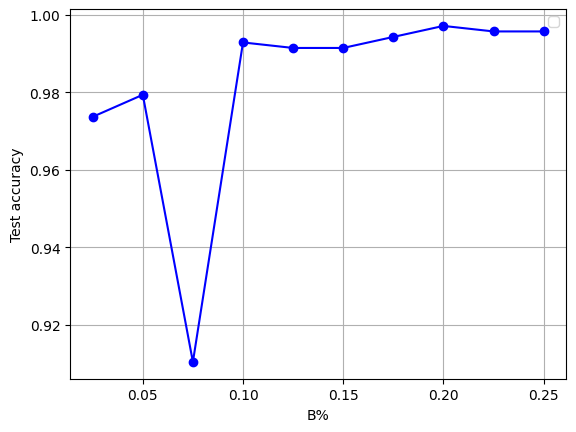

In [44]:
import matplotlib.pyplot as plt

# Plotting the second line graph
plt.plot(x_plot, y_plot, marker='o', color = 'b', linestyle='-')

# Adding labels, title, and legend
plt.xlabel('B%')
plt.ylabel('Test accuracy')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()


##Change in alpha

In [57]:

def load_data(G_dataset):
    server_model=Net(0.00)
    # Merge G_dataset with local client data
    '''test,train=train_test_split(G_dataset,test_size=test_size)
    trainlist=set_data(train)
    testlist=set_data(test)
    '''
    history = server_model.fit(
            G_dataset[0],
            G_dataset[1],
            learning_rate=best_learning_rate,
            num_epochs= 5,
            val_size=0.01,
        )
    
    return server_model


In [60]:
x_plot = []
y_plot = []
for G_size in range(10,21,10):
  df_client,df_global=train_test_split(traindata,test_size=(G_size/100))
  trainloaders,testloaders=data_split(df_client,"subcategory ",8,0.1,IID=0)
  tmp_x =[]
  tmp_y =[]
  for alpha in range(0,101,20):
    test_size = alpha/100
    G_dataset = df_global

    if test_size == 0:
      test_size = 0.1
    if test_size != 1:
      _,G_dataset=train_test_split(G_dataset,test_size=test_size)
    print(len(G_dataset))
    print(len(df_global))
    #Merge G with local client data
    for trainloader in trainloaders:
      trainloader = pd.concat([trainloader, G_dataset])
      trainloader = trainloader.sample(frac=1).reset_index(drop=True)


    global trainlist
    global testlist
    trainlist=set_data(trainloaders)
    testlist=set_data(testloaders)
    G_dataset=set_data([G_dataset])[0]
    server_model=load_data(G_dataset)
    tmp_x.append(alpha)
    params=server_model.get_parameter()
    #simulate
    strategy = fl.server.strategy.FedAvg( # Có thể tùy chọn chiến lược khác như FedAdagrad
        fraction_fit=1,  # Tỷ lệ các thiết bị người dùng được chọn để huấn luyện
        fraction_evaluate=0.5,  # Tỷ lệ các thiết bị người dùng được chọn để đánh giá hiệu suất
        min_fit_clients=NUM_CLIENTS,  # Số tối thiểu các thiết bị người dùng cần có trong quá trình huấn luyện
        min_evaluate_clients=5,  # Số tối thiểu các thiết bị người dùng cần có trong quá trình đánh giá
        min_available_clients=8,  # Wait until all 10 clients are available
        initial_parameters=fl.common.ndarrays_to_parameters(params),
        evaluate_fn=get_evaluate_fn_plot(model,tmp_y),  # Pass the evaluation function
        on_fit_config_fn=fit_config,  # Pass the fit_config function
    )
    fl.simulation.start_simulation( # Mô phỏng bằng cách gọi hàm
        client_fn=client_fn, # Một hàm để tạo ra các máy khách
        num_clients=NUM_CLIENTS, # Số lượng máy khách
        config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS), # Cấu hình cho máy chủ
        strategy=strategy, # Chiến lược huấn luyện và tổ chức dữ liệu
        server_model=server_model,
    )
  x_plot.append(tmp_x)
  y_plot.append(tmp_y)
    #Get array containing G_size, alpha, test_accuracy

prepairing non IID dataset
len of client data :5056, len of each subdata : 632
client number 1 : train(569), val(63)
client number 2 : train(569), val(63)
client number 3 : train(569), val(63)
client number 4 : train(569), val(63)
client number 5 : train(569), val(63)
client number 6 : train(569), val(63)
client number 7 : train(569), val(63)
client number 8 : train(569), val(63)
1
562
len X 569, len y 569
len X 569, len y 569
len X 569, len y 569
len X 569, len y 569
len X 569, len y 569
len X 569, len y 569
len X 569, len y 569
len X 569, len y 569
len X 63, len y 63
len X 63, len y 63
len X 63, len y 63
len X 63, len y 63
len X 63, len y 63
len X 63, len y 63
len X 63, len y 63
len X 63, len y 63
len X 1, len y 1


ValueError: With n_samples=1, test_size=0.01 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
#Plot
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(x_plot[0], y_plot[0], marker='o', color = 'r', linestyle='-', label ='B = 10%')

# Plotting the second line graph
plt.plot(x_plot[1], y_plot[1], marker='o', color = 'b', linestyle='-', label='B = 20%')

# Adding labels, title, and legend
plt.xlabel('alpha')
plt.ylabel('Test accuracy')
# plt.title('Two Lines on a Single Plot')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()


- tìm cách lấy test accuracy
- tìm hiểu cách plot -> tìm các tham số yêu cầu để plot theo ý thích -> rồi mới tạo array
- tìm hiểu SGD model, decay,
- accuracy quá thấp -> plot ra thì nó k hợp lí
